# Lecture 7

## Data Exploration

 - modelsummary package:             
   - datasummary for descriptives    
   - descriptive by categories       
   - custom function                 
 - ggplot                            
   - histogram                       
   - customize a ggplot              
   - kernel density                  
   - multiple geometries             
 - Hypothesis testing with t.test    
 - Association                       
   - scatter plot                    
   - bin-scatter:                    
       - equal distance              
       - equal number of obs         
   - correlation and covariance      
   - factors with ggplot             
                                     
#### Case-study:                           
- Billion Price Project:               
- Online and Offline prices           
                                     
#### Dataset:                              
- billion-prices 

___

Import packages

In [1]:
import pandas as pd
import numpy as np
from plotnine import *

Import data

In [2]:
bpp_original = pd.read_csv("https://osf.io/yhbr5/download", encoding="latin-1")

Check variables

In [3]:
bpp_original.head()

,COUNTRY,retailer,retailer_s,date,day,month,year,id,price,price_online,...,DEVICEID,TIME,ZIPCODE,PHOTO,OTHERSKUITEM,COMMENTS,PRICETYPE,CODE,sale_online,country_s
0,ARGENTINA,1,ARGENTINA_1,2015-03-19,19.0,3.0,2015.0,201209030113,429.0,429.0,...,891df49fb1b12aa0,21:03,8300,20150319_210351.jpg,NaN,NaN,NaN,124816.0,NaN,Argentina
1,ARGENTINA,1,ARGENTINA_1,2015-03-19,19.0,3.0,2015.0,4710268235965,189.0,189.0,...,891df49fb1b12aa0,21:26,8300,20150319_212653.jpg,NaN,NaN,NaN,124816.0,NaN,Argentina
2,ARGENTINA,1,ARGENTINA_1,2015-03-19,19.0,3.0,2015.0,4905524916874,6999.0,6999.0,...,891df49fb1b12aa0,21:19,8300,20150319_211929.jpg,NaN,NaN,NaN,124816.0,NaN,Argentina
3,ARGENTINA,1,ARGENTINA_1,2015-03-19,19.0,3.0,2015.0,4905524925784,1999.0,2099.0,...,891df49fb1b12aa0,21:08,8300,20150319_210847.jpg,NaN,NaN,NaN,124816.0,NaN,Argentina
4,ARGENTINA,1,ARGENTINA_1,2015-03-19,19.0,3.0,2015.0,4905524931310,2899.0,2899.0,...,891df49fb1b12aa0,21:06,8300,20150319_210627.jpg,NaN,NaN,NaN,124816.0,NaN,Argentina


Create our key variable: price differences

In [4]:
bpp_original["p_diff"] = bpp_original["price_online"] - bpp_original["price"]

## Descriptive statistics

Check all the variables in DataFrame by a quick built-in summary statistics

In [5]:
bpp_original.describe()

,retailer,day,month,year,price,price_online,imputed,CODE,sale_online,p_diff
count,45253.000000,44928.000000,44928.000000,44928.000000,4.525300e+04,45253.000000,22414.0,42233.000000,4144.0,4.525300e+04
mean,34.087751,15.743523,5.301126,2015.079817,1.737368e+04,353.416684,1.0,181441.070253,1.0,-1.702027e+04
std,19.149542,8.440930,3.440339,1.035976,2.671665e+06,5269.492998,0.0,158106.823327,0.0,2.671661e+06
min,1.000000,1.000000,1.000000,2000.000000,0.000000e+00,0.030000,1.0,112190.000000,1.0,-5.534910e+08
25%,16.000000,9.000000,3.000000,2015.000000,7.000000e+00,6.990000,1.0,124816.000000,1.0,0.000000e+00
50%,37.000000,16.000000,5.000000,2015.000000,1.999000e+01,19.990000,1.0,124816.000000,1.0,0.000000e+00
75%,50.000000,23.000000,8.000000,2015.000000,5.799000e+01,56.990000,1.0,124816.000000,1.0,0.000000e+00
max,62.000000,31.000000,12.000000,2016.000000,5.534910e+08,261690.000000,1.0,856681.000000,1.0,2.330700e+05


Compare key variables

In [6]:
bpp_original.filter(["price", "price_online","p_diff"]).describe()

,price,price_online,p_diff
count,4.525300e+04,45253.000000,4.525300e+04
mean,1.737368e+04,353.416684,-1.702027e+04
std,2.671665e+06,5269.492998,2.671661e+06
min,0.000000e+00,0.030000,-5.534910e+08
25%,7.000000e+00,6.990000,0.000000e+00
50%,1.999000e+01,19.990000,0.000000e+00
75%,5.799000e+01,56.990000,0.000000e+00
max,5.534910e+08,261690.000000,2.330700e+05


Put the descriptives into columns and variables into rows

In [7]:
bpp_original.filter(["price", "price_online","p_diff"]).describe().transpose()

,count,mean,std,min,25%,50%,75%,max
price,45253.0,17373.683164,2.671665e+06,0.000000e+00,7.00,19.99,57.99,553490984.0
price_online,45253.0,353.416684,5.269493e+03,3.000000e-02,6.99,19.99,56.99,261690.0
p_diff,45253.0,-17020.266480,2.671661e+06,-5.534910e+08,0.00,0.00,0.00,233070.0


Next let us check the price differences for each countries.

For this, you need to group the data and apply the required statistics to the appropriate columns

In [8]:
bpp_original.groupby("COUNTRY").agg(
    mean_price_diff=("p_diff", "mean"), median_price_diff=("p_diff", "median")
)

,mean_price_diff,median_price_diff
COUNTRY,,
ARGENTINA,-30399.085151,0.0
AUSTRALIA,-0.464439,0.0
BRAZIL,-37.924121,0.0
CANADA,0.588671,0.0
CHINA,-0.832808,0.0
GERMANY,4.577242,0.0
JAPAN,-586.881969,0.0
SOUTHAFRICA,-125.700372,0.0
UK,-0.067043,0.0


Lets say we are interested in the prices as well for each countries.

In [9]:
(
    bpp_original.melt(
        id_vars=["COUNTRY"], value_vars=["price", "price_online", "p_diff"]
    )
    .groupby(["COUNTRY", "variable"])
    .agg(Mean=("value", "mean"), Median=("value", "median"))
)

Mean   Median
COUNTRY     variable                           
ARGENTINA   p_diff       -30399.085151     0.00
            price         31061.999723    54.95
            price_online    662.914572    55.00
AUSTRALIA   p_diff           -0.464439     0.00
            price            22.126683     7.99
            price_online     21.662243     8.00
BRAZIL      p_diff          -37.924121     0.00
            price           338.507332    69.90
            price_online    300.583211    67.90
CANADA      p_diff            0.588671     0.00
            price            35.799147    17.98
            price_online     36.387818    17.99
CHINA       p_diff           -0.832808     0.00
            price           141.923942    43.85
            price_online    141.091135    43.90
GERMANY     p_diff            4.577242     0.00
            price            31.831955    14.99
            price_online     36.409198    15.99
JAPAN       p_diff         -586.881969     0.00
            price          5508.326655  1180.00
            price_online   4921.444686   973.00
SOUTHAFRICA p_diff         -125.700372     0.00
            price           208.401621    39.99
            price_online     82.701249    39.99
UK          p_diff           -0.067043     0.00
            price             7.841262     2.00
            price_online      7.774219     2.00
USA         p_diff       -31950.531931     0.00
            price         31985.195144    14.99
            price_online     34.663213    14.99

### Task
1) filter the data to 2016 and check price difference the mean and median for each country

In [10]:
(
    bpp_original.loc[lambda x: x["year"] == 2016]
    .groupby("COUNTRY")
    .agg(Mean=("p_diff", "mean"), Median=("p_diff", "median"))
)

,Mean,Median
COUNTRY,,
BRAZIL,-0.030662,0.0
CHINA,-0.345833,0.0
GERMANY,-0.192795,0.0
JAPAN,-91.596026,0.0
SOUTHAFRICA,-31.412899,0.0
USA,-139.610604,0.0


Add self created descriptive function to groupby().agg()

Lets check the 'range' as an external function to the descriptive

In [11]:
def range_function(x):
    return x.max() - x.min()


bpp_original.groupby("COUNTRY").agg(
    mean_price_diff=("p_diff", "mean"),
    median_price_diff=("p_diff", "median"),
    range_price_diff=("p_diff", range_function),
)

,mean_price_diff,median_price_diff,range_price_diff
COUNTRY,,,
ARGENTINA,-30399.085151,0.0,1.111358e+08
AUSTRALIA,-0.464439,0.0,1.438310e+03
BRAZIL,-37.924121,0.0,3.429000e+03
CANADA,0.588671,0.0,5.250200e+02
CHINA,-0.832808,0.0,6.110900e+02
GERMANY,4.577242,0.0,1.098310e+03
JAPAN,-586.881969,0.0,4.155930e+05
SOUTHAFRICA,-125.700372,0.0,2.075375e+05
UK,-0.067043,0.0,5.446000e+01


Later we will discuss functions more in details!

## Visualisation

We use the plotnine package for visualization in Python. This package relates to the ggplot package in R. 

plotnine always has a `ggplot()` function and a `geom_*type*()` function added.

___

Check the empirical distribution:  histogram.

Before building a nice looking graph using plotnine, its worth to look at the histogram using thew built in pandas `hist()` function

<AxesSubplot:>

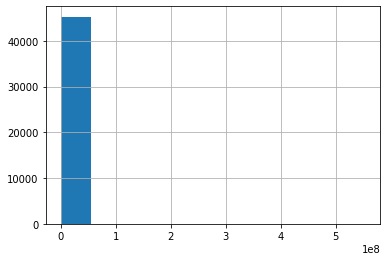

In [12]:
bpp_original.price.hist()

It is clear: need to filter out some data!

In [13]:
bpp = (
    bpp_original.loc[lambda x: x["sale_online"].isnull()] ## ASK GABOR, WHY keep nulls
    .loc[lambda x: x["price"].notnull()]
    .loc[lambda x: x["price_online"].notnull()]
    .loc[lambda x: x["PRICETYPE"] == "Regular Price"]
)

Check our newly created data:

In [14]:
bpp.filter(["price", "price_online","p_diff"]).describe()

,price,price_online,p_diff
count,8.169000e+03,8169.00000,8.169000e+03
mean,7.650828e+03,133.36461,-7.517463e+03
std,6.641562e+05,495.47564,6.641574e+05
min,2.500000e-01,0.25000,-6.002112e+07
25%,5.990000e+00,5.99000,-1.000000e-01
50%,1.499000e+01,14.99000,0.000000e+00
75%,4.399000e+01,44.95000,0.000000e+00
max,6.002113e+07,6362.00000,9.200100e+02


Drop obvious errors: price is larger than $1000

In [15]:
bpp = bpp.loc[lambda x: x["price"] < 1000]

In [16]:
bpp.filter(["price", "price_online","p_diff"]).describe()

,price,price_online,p_diff
count,7893.000000,7893.000000,7893.000000
mean,55.211356,54.913554,-0.297802
std,135.469561,134.315549,20.141510
min,0.250000,0.250000,-380.130000
25%,5.990000,5.790000,0.000000
50%,14.490000,13.990000,0.000000
75%,38.190000,39.000000,0.000000
max,970.000000,970.000000,920.010000


<AxesSubplot:>

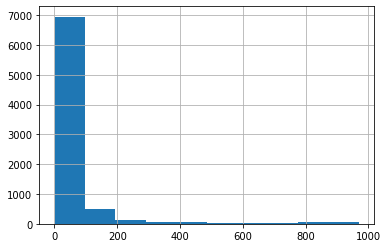

In [17]:
bpp.price.hist()

Make a nice histogram using plotnine

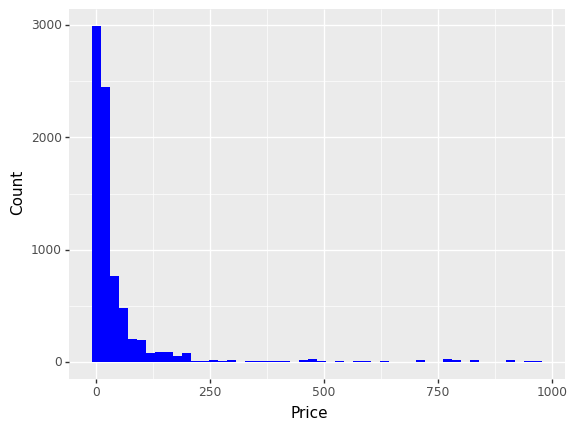

<ggplot: (373836320)>

In [18]:
(
    ggplot(data=bpp)
    + geom_histogram(aes(x="price"), bins=50, fill="blue")
    + labs(x="Price", y="Count")
)

### Role of number of bins (or binwidth)

Play with the number of Bins:

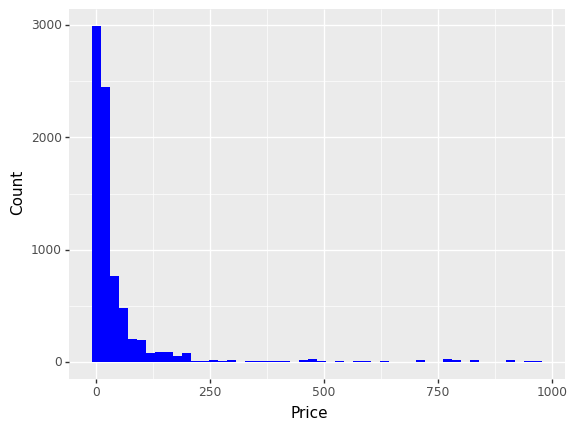

<ggplot: (373836317)>

In [19]:
# 1) approx ok
(
    ggplot(data=bpp)
    + geom_histogram(aes(x="price"), bins=50, fill="blue")
    + labs(x="Price", y="Count")
)

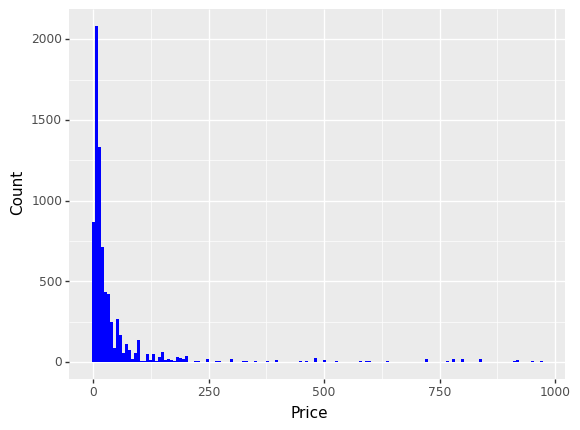

<ggplot: (373836602)>

In [20]:

# 2) too many
(
    ggplot(data=bpp)
    + geom_histogram(aes(x="price"), bins=150, fill="blue")
    + labs(x="Price", y="Count")
)

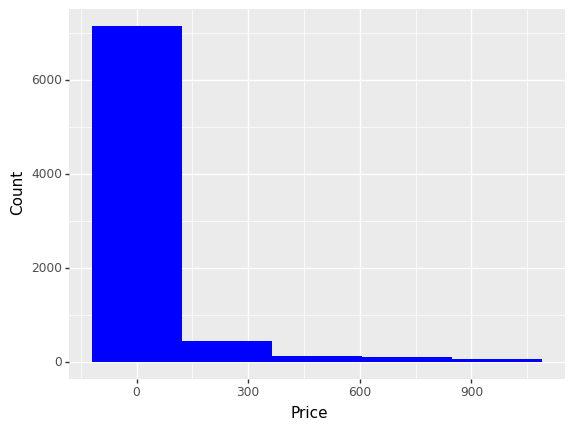

<ggplot: (373925255)>

In [21]:

# 3) too few
(
    ggplot(data=bpp)
    + geom_histogram(aes(x="price"), bins=5, fill="blue")
    + labs(x="Price", y="Count")
)

#### Task:
 Play with the binwidth - instead of `bins=`, use `binwidth=`
 
 create 3 graphs: 1) approx ok, 2) too large binwidth, 3) too narrow binwidth
 
 discuss, what is the relation between bins and binwidth!

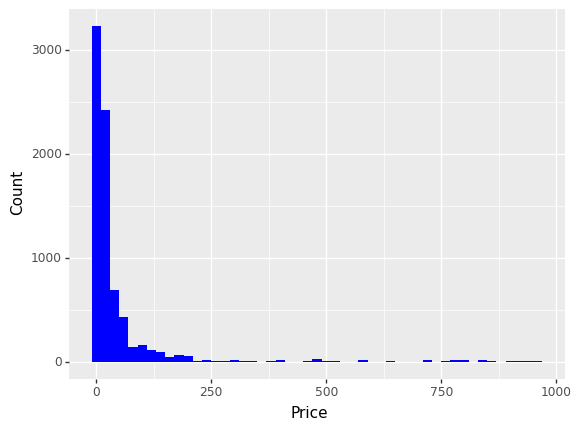

<ggplot: (373917555)>

In [22]:
# 1) approx ok
(
    ggplot(data=bpp)
    + geom_histogram(aes(x="price"), binwidth=20, fill="blue")
    + labs(x="Price", y="Count")
)

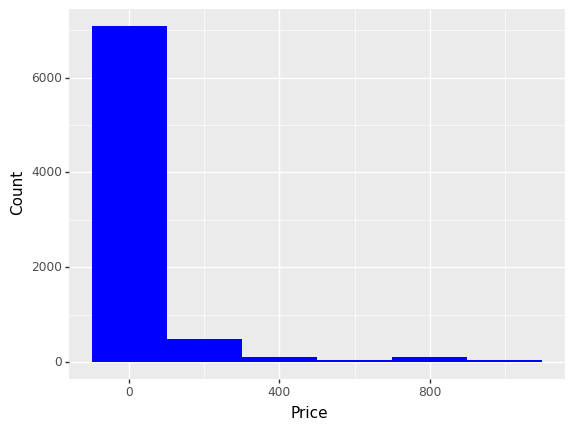

<ggplot: (373993677)>

In [23]:

# 2) too many
(
    ggplot(data=bpp)
    + geom_histogram(aes(x="price"), binwidth=200, fill="blue")
    + labs(x="Price", y="Count")
)

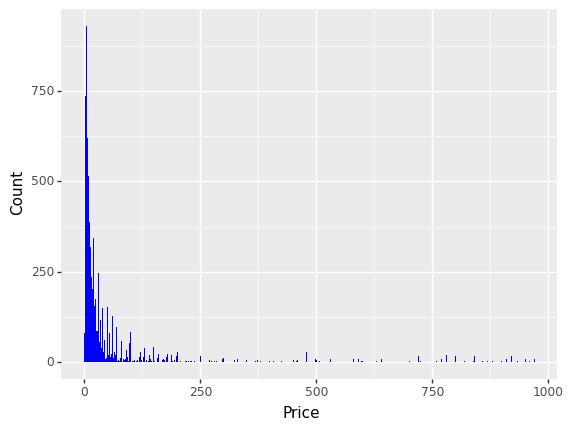

<ggplot: (374056261)>

In [24]:

# 3) too few
(
    ggplot(data=bpp)
    + geom_histogram(aes(x="price"), binwidth=2, fill="blue")
    + labs(x="Price", y="Count")
)

 Relation: they are inversely proportional

___

### Count vs. Relative Frequency

Until now we have used count (counted the number of observations in each bin)

The other possibility is to use relative frequency instead:

You need to add `y = after_stat('density')` to the aesthetics:

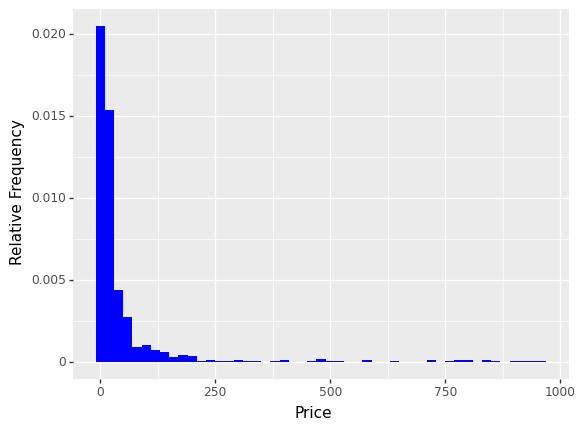

<ggplot: (373989800)>

In [25]:
(
    ggplot(data=bpp)
    + geom_histogram(aes(x="price", y=after_stat("density")), binwidth=20, fill="blue")
    + labs(x="Price", y="Relative Frequency")
)

 ### Kernel density

 Histogram or kernel density? Kernel is the smooth line instead of using bars.
 
 Now, let us name our ggplot:

In [26]:
my_graph = (
    ggplot(data=bpp)
    + geom_density(aes(x="price"), fill="red", alpha=0.1, bw=20)
    + labs(x="Price", y="Relative Frequency")
)

to make it visible we need to call it

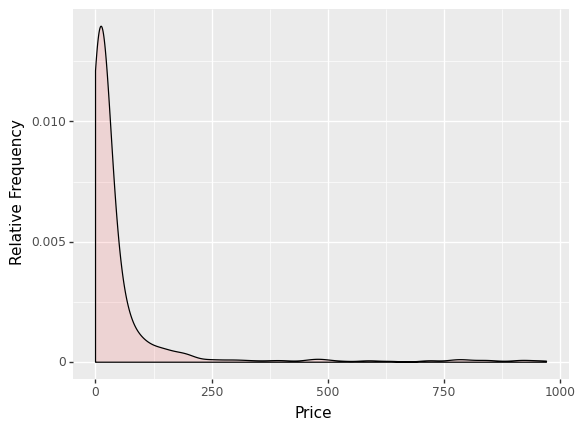

<ggplot: (373926795)>

In [27]:
my_graph

Cool stuff about plotnine, is that we can add (later as well) new geometric object to it.

e.g. we can add a histogram:

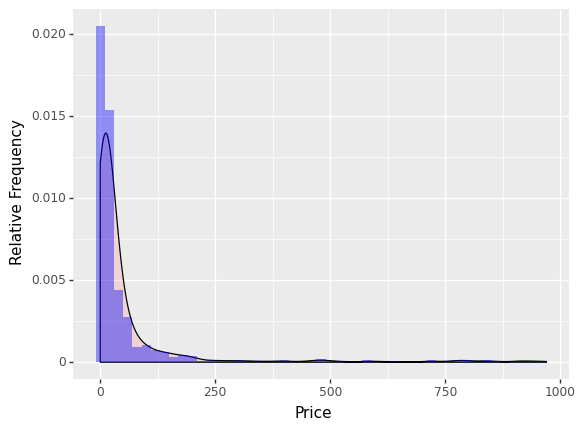

<ggplot: (374835918)>

In [28]:
my_graph + geom_histogram(
    aes(x="price", y=after_stat("density")), binwidth=20, fill="blue", alpha=0.4
)

### Task
1) Do the same kernel density and histogram, but now with the price differences!

2) Add xlim(-5,5) command to ggplot! What changed?

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/plotnine/layer.py:334: PlotnineWarning: stat_density : Removed 418 rows containing non-finite values.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/plotnine/layer.py:334: PlotnineWarning: stat_bin : Removed 418 rows containing non-finite values.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/plotnine/layer.py:412: PlotnineWarning: geom_histogram : Removed 2 rows containing missing values.


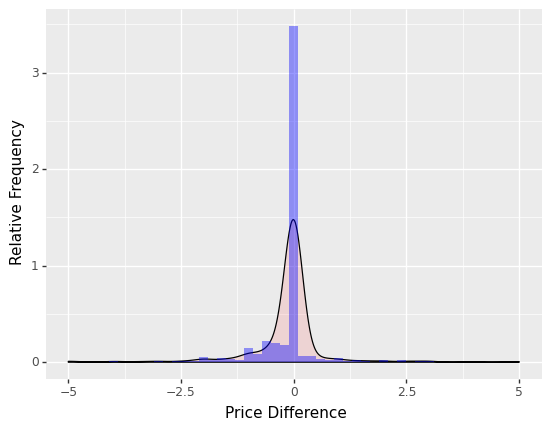

<ggplot: (374195747)>

In [29]:
(
    ggplot(data=bpp)
    + geom_density(aes(x="p_diff"), fill="red", alpha=0.1, bw=0.2)
    + geom_histogram(
        aes(x="p_diff", y=after_stat("density")), binwidth=0.2, fill="blue", alpha=0.4
    )
    + xlim(-5,5)
    + labs(x="Price Difference", y="Relative Frequency")
)

Check for high price differences

In [30]:
bpp.loc[lambda x: (x["p_diff"] > 500) | (x["p_diff"] < -500)]

,COUNTRY,retailer,retailer_s,date,day,month,year,id,price,price_online,...,TIME,ZIPCODE,PHOTO,OTHERSKUITEM,COMMENTS,PRICETYPE,CODE,sale_online,country_s,p_diff
16971,GERMANY,27,GERMANY_27,2015-12-07,7.0,12.0,2015.0,1682592,22.99,539.0,...,16:36,67663,20151207_163638.jpg,1682592,NaN,Regular Price,768619.0,NaN,Germany,516.01
17056,GERMANY,27,GERMANY_27,2015-12-07,7.0,12.0,2015.0,4612636,8.99,929.0,...,17:34,67663,20151207_173447.jpg,4612636,NaN,Regular Price,768619.0,NaN,Germany,920.01


Remove them

In [31]:
bpp = bpp.loc[lambda x: (x["p_diff"] < 500) & (x["p_diff"] > -500)]

### Comparing different countries via graphs

Create plot for each countries - histogram:

Note: 

  1) if you only use one type of x or y, you can put it into the `aes()` of the ggplot. Otherwise not. \
  2) use 'fill=' in `aes()`, to define different groups. 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/plotnine/layer.py:334: PlotnineWarning: stat_bin : Removed 494 rows containing non-finite values.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/plotnine/layer.py:412: PlotnineWarning: geom_histogram : Removed 12 rows containing missing values.


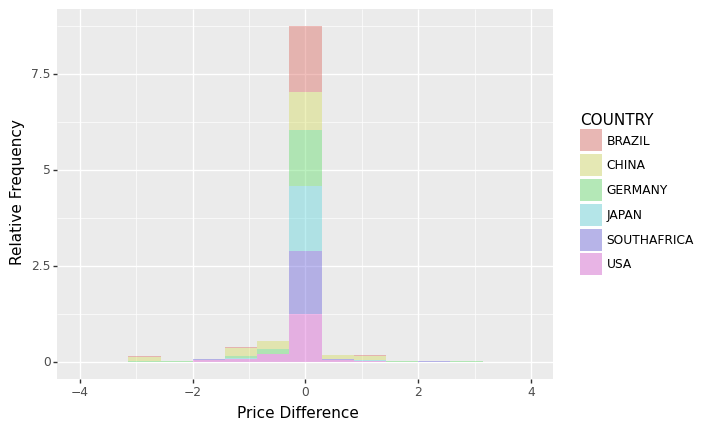

<ggplot: (374845155)>

In [32]:
(
    ggplot(bpp, aes(x="p_diff", fill="COUNTRY"))
    + geom_histogram(aes(y=after_stat("density")), bins=15, alpha=0.4)
    + xlim(-4, 4)
    + labs(x="Price Difference", y="Relative Frequency")
)

Use the extra command `facet_wrap(~COUNTRY)` to create multiple plots for each country at once!

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/plotnine/layer.py:334: PlotnineWarning: stat_bin : Removed 494 rows containing non-finite values.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/plotnine/layer.py:412: PlotnineWarning: geom_histogram : Removed 12 rows containing missing values.


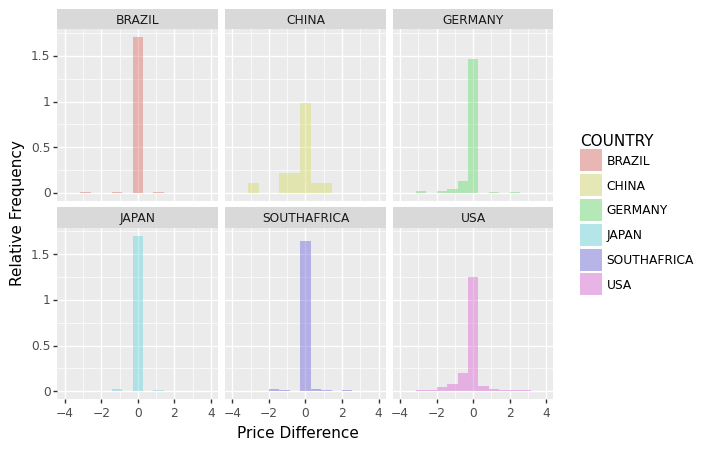

<ggplot: (374335810)>

In [33]:
(
    ggplot(bpp, aes(x="p_diff", fill="COUNTRY"))
    + geom_histogram(aes(y=after_stat("density")), bins=15, alpha=0.4)
    + xlim(-4, 4)
    + labs(x="Price Difference", y="Relative Frequency")
    + facet_wrap("~COUNTRY")
)

### Task 
1) You can also use  'color=' or 'group=' instead of 'fill='. Compare! What is the difference? \

Use color instead

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/plotnine/layer.py:334: PlotnineWarning: stat_bin : Removed 494 rows containing non-finite values.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/plotnine/layer.py:412: PlotnineWarning: geom_histogram : Removed 12 rows containing missing values.


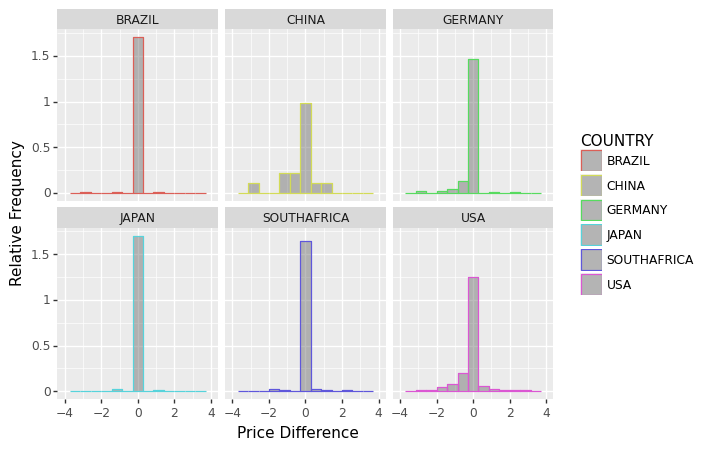

<ggplot: (374294607)>

In [34]:
(
    ggplot(bpp, aes(x="p_diff", color="COUNTRY"))
    + geom_histogram(aes(y=after_stat("density")), bins=15, alpha=0.4)
    + xlim(-4, 4)
    + labs(x="Price Difference", y="Relative Frequency")
    + facet_wrap("~COUNTRY")
)

Use group instead

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/plotnine/layer.py:334: PlotnineWarning: stat_bin : Removed 494 rows containing non-finite values.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/plotnine/layer.py:412: PlotnineWarning: geom_histogram : Removed 12 rows containing missing values.


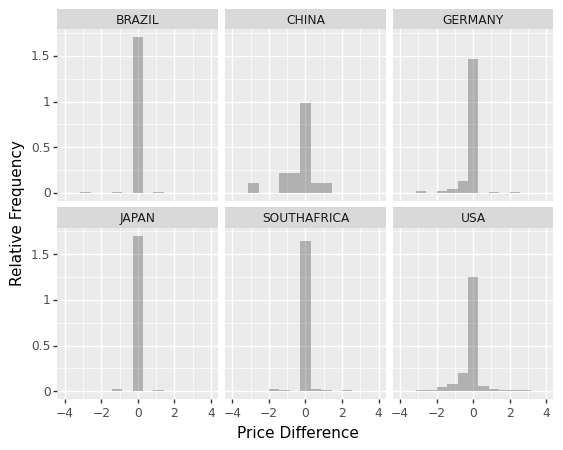

<ggplot: (374913841)>

In [35]:
(
    ggplot(bpp, aes(x="p_diff", group="COUNTRY"))
    + geom_histogram(aes(y=after_stat("density")), bins=15, alpha=0.4)
    + xlim(-4, 4)
    + labs(x="Price Difference", y="Relative Frequency")
    + facet_wrap("~COUNTRY")
)

### Task

1) Do the same, but use geom_density instead of geom_histogram! \
    You may play around with the xlim!\
2) Drop the `facet_wrap` command! What happens? Which graph would you use to tell your story in this case?\
What if instead of `fill` you use `color` or `group`\

 1) Density with multiple graphs

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/plotnine/layer.py:334: PlotnineWarning: stat_density : Removed 1121 rows containing non-finite values.


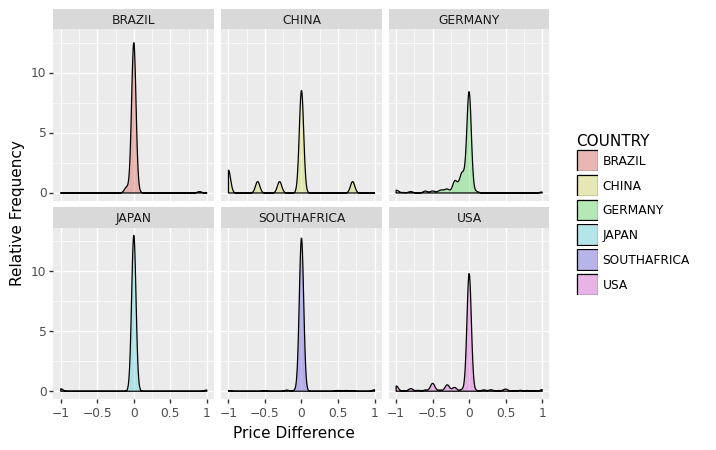

<ggplot: (383240991)>

In [36]:
(
    ggplot(bpp, aes(x="p_diff", fill="COUNTRY"))
    + geom_density(alpha=0.4, bw = 0.03)
    + xlim(-1, 1)
    + labs(x="Price Difference", y="Relative Frequency")
    + facet_wrap("~COUNTRY")
)

2) Density with single graphs:

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/plotnine/layer.py:334: PlotnineWarning: stat_density : Removed 1121 rows containing non-finite values.


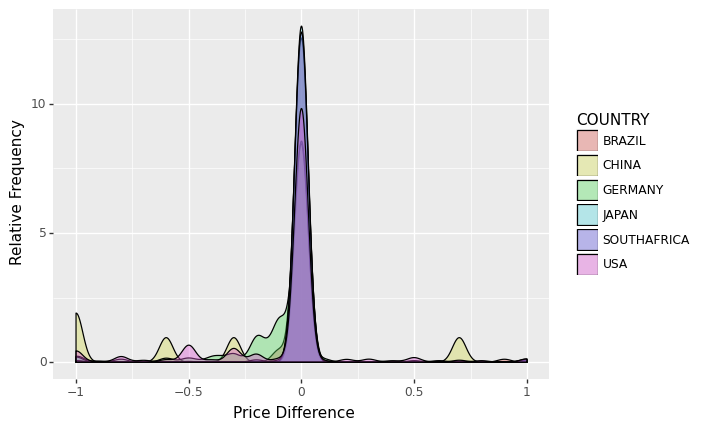

<ggplot: (374976642)>

In [37]:
# fill
(
    ggplot(bpp, aes(x="p_diff", fill="COUNTRY"))
    + geom_density(alpha=0.4, bw = 0.03)
    + xlim(-1, 1)
    + labs(x="Price Difference", y="Relative Frequency")
)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/plotnine/layer.py:334: PlotnineWarning: stat_density : Removed 1121 rows containing non-finite values.


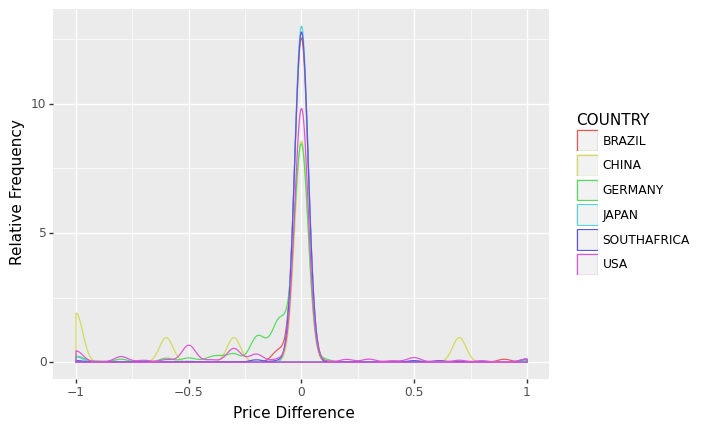

<ggplot: (374959663)>

In [38]:
# color
(
    ggplot(bpp, aes(x="p_diff", color="COUNTRY"))
    + geom_density(alpha=0.4, bw = 0.03)
    + xlim(-1, 1)
    + labs(x="Price Difference", y="Relative Frequency")
)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/plotnine/layer.py:334: PlotnineWarning: stat_density : Removed 1121 rows containing non-finite values.


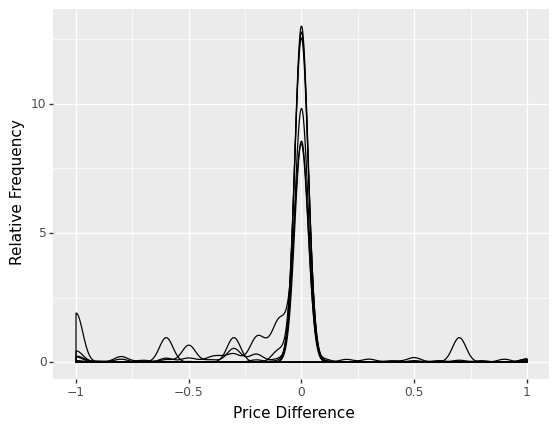

<ggplot: (374205197)>

In [39]:
# group
(
    ggplot(bpp, aes(x="p_diff", group="COUNTRY"))
    + geom_density(alpha=0.4, bw = 0.03)
    + xlim(-1, 1)
    + labs(x="Price Difference", y="Relative Frequency")
)

Which graph to use: I would definitely use single density graph with color. \
    It tells the story best: there are differences between countries!

## Hypothesis testing

Test 1: 

H0: the average price difference between price_online - price = 0 \
HA: the avg price diff is non 0.

In [40]:
from scipy import stats

In [41]:
stats.ttest_1samp(bpp["p_diff"], 0)

Ttest_1sampResult(statistic=-2.620422555460335, pvalue=0.008798916974747767)

Test 2: The online prices are smaller or equal to offline prices
  
H0: price_online - price = 0 \
HA: price_online - price >  0

In [42]:
stats.ttest_1samp(bpp["p_diff"], 0, alternative = "greater")

Ttest_1sampResult(statistic=-2.620422555460335, pvalue=0.9956005415126261)

Test 3: The online prices are larger or equal to offline prices
    
  H0: price_online - price = 0 \
  HA: price_online - price <  0

In [43]:
stats.ttest_1samp(bpp["p_diff"], 0, alternative = "less")

Ttest_1sampResult(statistic=-2.620422555460335, pvalue=0.004399458487373884)

Let us create multiple hypothesis tests: \
Check the hypothesis that online prices are the same as offline for each country!

In [44]:
testing = bpp.groupby("COUNTRY").agg(
    mean_pdiff=("p_diff", "mean"),
    se_pdiff=("p_diff","sem"),
    num_obs=("p_diff", "count"),
)
testing

,mean_pdiff,se_pdiff,num_obs
COUNTRY,,,
BRAZIL,-0.905328,0.784719,122
CHINA,-0.510526,0.841118,19
GERMANY,3.679738,1.865770,420
JAPAN,-11.982857,2.146688,350
SOUTHAFRICA,-2.529723,0.831934,541
USA,0.054460,0.124552,6439


Testing is easy if one understands the theory! \
t_stat: with this H0 and t-test: 

In [45]:
testing["t_stat"] = testing["mean_pdiff"] / testing["se_pdiff"]

testing

,mean_pdiff,se_pdiff,num_obs,t_stat
COUNTRY,,,,
BRAZIL,-0.905328,0.784719,122,-1.153697
CHINA,-0.510526,0.841118,19,-0.606962
GERMANY,3.679738,1.865770,420,1.972236
JAPAN,-11.982857,2.146688,350,-5.582022
SOUTHAFRICA,-2.529723,0.831934,541,-3.040772
USA,0.054460,0.124552,6439,0.437248


Calculate p-values

In [46]:
testing["p_val"] = stats.t.sf(abs(testing["t_stat"]), df=testing["num_obs"] - 1)

testing

,mean_pdiff,se_pdiff,num_obs,t_stat,p_val
COUNTRY,,,,,
BRAZIL,-0.905328,0.784719,122,-1.153697,1.254490e-01
CHINA,-0.510526,0.841118,19,-0.606962,2.757282e-01
GERMANY,3.679738,1.865770,420,1.972236,2.461995e-02
JAPAN,-11.982857,2.146688,350,-5.582022,2.390995e-08
SOUTHAFRICA,-2.529723,0.831934,541,-3.040772,1.237115e-03
USA,0.054460,0.124552,6439,0.437248,3.309730e-01


Round it to 4 digits

In [47]:
testing["p_val"] = testing["p_val"].round(4)
testing

,mean_pdiff,se_pdiff,num_obs,t_stat,p_val
COUNTRY,,,,,
BRAZIL,-0.905328,0.784719,122,-1.153697,0.1254
CHINA,-0.510526,0.841118,19,-0.606962,0.2757
GERMANY,3.679738,1.865770,420,1.972236,0.0246
JAPAN,-11.982857,2.146688,350,-5.582022,0.0000
SOUTHAFRICA,-2.529723,0.831934,541,-3.040772,0.0012
USA,0.054460,0.124552,6439,0.437248,0.3310


Interpret the results for each country! \
What are the possible dangers of multiple hypothesis testing?

## Association

Relation between two variables

Association between online and retail prices: geom_point() will add dots to the graph

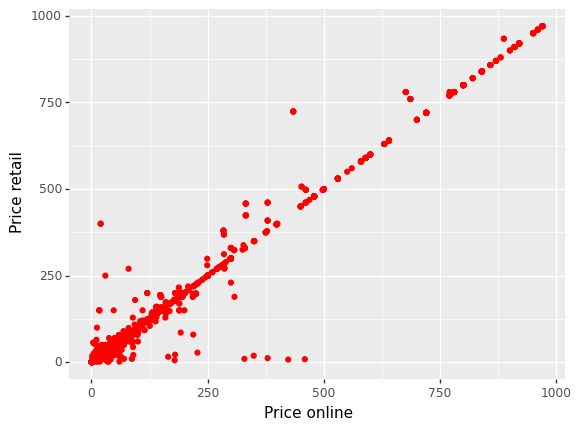

<ggplot: (373991941)>

In [48]:
(
    ggplot(bpp, aes(x="price_online", y="price"))
    + geom_point(color="red")
    + labs(x="Price online", y="Price retail")
)

You can add a line (regression line to be specific),\
  by `geom_smooth()` function. It is a great function, \
     we now focus on `method=lm` which says it is a linear relation (linear model) \
     and formula, which identifies y and x. We will discuss these more in details later.

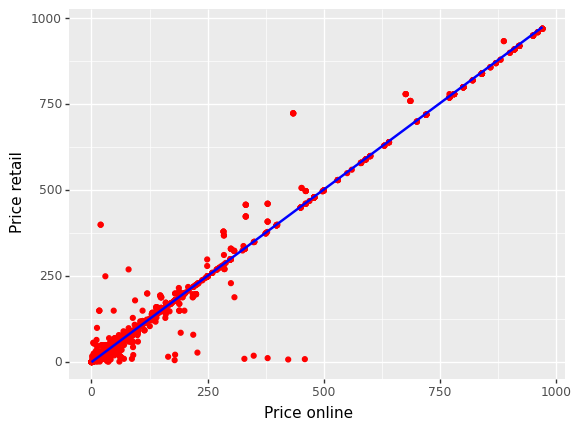

<ggplot: (383400012)>

In [49]:
(
    ggplot(bpp, aes(x="price_online", y="price"))
    + geom_point(color="red")
    + geom_smooth(method = "lm", formula = "y ~ x", color = "blue")
    + labs(x="Price online", y="Price retail")
)

### Bin-scatter:

In many case there are too many observations for a simple graph \
  and it does not tells the story we would like to. \
One solution is to do a `bin-scatter`, which put observations into bins. \
  The simplest way to do is use "equal distances": cut x-variable's range into k equally sized bins \
    and then calculate the same observations' y-variable e.g. mean (or median). \ 
    - this is great: simple and intuitive (similar to histogram), \
      BUT it hides, how many observations are in each bin. \
        E.g. it can happen in the lowest valued bin there are many observations \
            and in the highest there is only one. \
       
  The second option is use the same number of observations in each bin. \
    This will ensure that no such problem will rise. On the other hand it is harder to compute, \
     and the width of the bins will vary along x.\

1) 'easy way': using equal distances and calculate mean for y
   use `stat_summary_bin()`

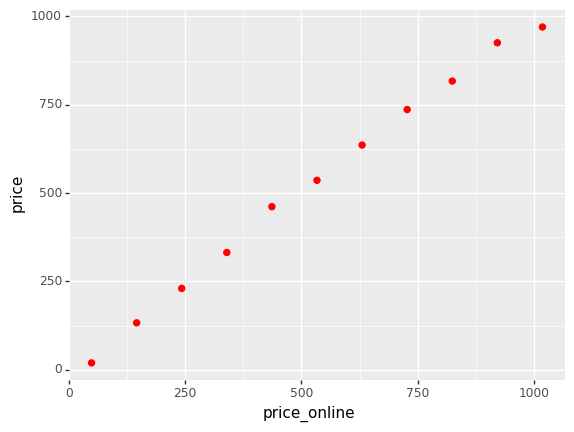

<ggplot: (383595824)>

In [50]:
ggplot(bpp, aes(x="price_online", y="price")) + stat_summary_bin(
    fun_data="mean_se", bins=10, geom="point", color="red", size=2
)

2) 'easy way': using equal distances
   group by countries, explain facet_wrap additional inputs!

In [ ]:
(
    ggplot(bpp, aes(x="price_online", y="price", color="COUNTRY"))
    + stat_summary_bin(fun_data="mean_se", bins=10, geom="point", size=2)
    + labs(x="Price online", y="Price offline", color="Country")
    + facet_wrap("~COUNTRY", scales="free", ncol=2)
    + theme(legend_position="none")
    + geom_smooth(method="lm", formula="y~x", se = False)
)

#### Bin-scatter 2 

Using percentiles instead of equally sized bins to ensure same number of observations!

As there is no built-in function for this, we need to do some work:

First, cut the y variable into 10 equally sized categories

In [ ]:
bpp["price_online_10b"] = pd.qcut(bpp["price_online"], 10).values

Select these new intervals and the y-variable \
then group by the intervals and calculate some descriptive statistics! \
from these descriptive statistics we can choose which to show on the y-axis!

In [ ]:
bpp.groupby("price_online_10b").agg(
    p_min=("price", "min"),
    p_max=("price", "max"),
    p_mean=("price", "mean"),
    p_median=("price", "median"),
    p_sd=("price", "std"),
    p_num_obs=("price", "count"),
)

Get mean of each category for x axis labels

In [ ]:
bpp["mid_point"] = bpp.groupby("price_online_10b")["price_online"].transform("mean")

Now, calculate mean price for each midpoint

In [ ]:
bs_summary = bpp.groupby("mid_point")["price"].mean().reset_index()

In [ ]:
bs_summary

In [ ]:
(
    ggplot(bs_summary, aes(x="mid_point", y="price"))
    + geom_point()
    + geom_point(size=2, color="red")
    + labs(x="Online prices", y="Retail prices")
)

Add x and y limits to check smaller values

In [ ]:
(
    ggplot(bs_summary, aes(x="mid_point", y="price"))
    + geom_point()
    + geom_point(size=2, color="red")
    + labs(x="Online prices", y="Retail prices")
    + xlim(0, 100)
    + ylim(0, 100)
)

## Correlation and plots with factors

Often we would like to measure an association: \
covariance and correlation for mean-dependence

Covariance matrix

In [ ]:
bpp.filter(["price","price_online"]).cov()

Correlation

In [ ]:
bpp.filter(["price","price_online"]).corr()

Make a correlation table, including correlation for each country

In [ ]:
corr_table = bpp.groupby("COUNTRY")["price"].corr(bpp["price_online"]).rename("correlation").reset_index()

corr_table

Graph to show the correlation pattern by each country: \
"reorder" will reorder the countries by their correlation

In [ ]:
(
    ggplot(corr_table, aes(x="correlation", y="reorder(COUNTRY, correlation)"))
    + geom_point(color="red", size=2)
    + labs(y="Countries", x="Correlation")
)

### Task

Check the same for years and countries to check how the pattern altered!

Note: \
    1) use color for prettier output with factor \
    2) You can alter the legend labels with `color=`

In [ ]:
corr_table2 = bpp.groupby(["year","COUNTRY"])["price"].corr(bpp["price_online"]).rename("correlation").reset_index()

corr_table2

In [ ]:
(
    ggplot(
        corr_table2,
        aes(x="correlation", y="reorder(COUNTRY, correlation)", color="factor(year)"),
    )
    + geom_point(size=2)
    + labs(y="Countries", x="Correlation", color="Year")
)